# コードのテスト
## ensemble_predict.py の関数について
- 複数モデルの推定確率の（アンサンブル）平均をとる

In [1]:
import os
gpu_num = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_num)

# モジュールimport
import os, sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
path = os.path.join(current_dir, '../../')
sys.path.append(path)
from dataset import plot_log, prepare_data, util
from transformer import get_train_valid_test
from model import define_model, multi_loss, my_callback, my_metric
from predicter import roc_curve, conf_matrix, multi_predict, grad_cam

import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt

sys.path.append(r'/home/tmp10014/jupyterhub/notebook/other/lib_DL/mixup-generator')
from random_eraser import get_random_eraser

plot_log.py: loaded as module file
prepare_data.py: loaded as module file
util.py: loaded as module file


Using TensorFlow backend.
/home/tmp10014/.conda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


get_train_valid_test.py: loaded as module file
define_model.py: loaded as module file
multi_loss.py: loaded as module file
my_callback.py: loaded as module file
my_metric.py: loaded as module file
roc_curve.py: loaded as module file
conf_matrix.py: loaded as module file
multi_predict.py: loaded as module file
grad_cam.py: loaded as module file


## ensemble_predict.ensembling_soft_from_task12_tsv
- ensemble_predict.py は内部にprint張らないと確認できなかったので、以下の関数はensemble_predict.ensembling_soft_from_task12_tsv()のコピー

In [2]:
import os, sys, glob
import numpy as np
import pandas as pd

# /gpfsx01/home/aaa00162/jupyterhub/notebook/work_H3-038/work/03.Tox21_work_refine/predicter
# ensemble_predict.py のensembling_soft_from_task12_tsv(dirs)
def ensembling_soft_from_task12_tsv(dirs):
    """
    Roc図書くときに使うy_true, y_predのtsvファイルから、行ごとにy_predの平均を取るソフトアンサンブル
    Args:
        dirs:タスクごとにRoc図書くときに使うy_true, y_predのtsvファイルを格納しているディレクトリパスのリスト
    Returns:
        y_true_list:タスクごとの正解ラベルのリスト
        y_pred_ensemble_list:タスクごとに平均を取ったラベルの推定確率リスト
    """
    pred_df_sum = None
    for dir in dirs:
        # taskごとのtsvファイル
        files = glob.glob(dir+'/*tsv')
        files.sort()
        # ディレクトリ単位で12taskのpredデータフレーム作成
        true_df = None
        pred_df = None
        for f in files:
            df = pd.read_csv(f, sep = '\t')
            df.rename(columns={'y_true': 't_'+os.path.basename(f), 'y_pred': 'p_'+os.path.basename(f)}, inplace=True)
            if true_df is None:
                true_df = pd.DataFrame(df.iloc[:,[0]])
                pred_df = pd.DataFrame(df.iloc[:,[1]])
            else:
                # 2ファイル以降はconcat（単純な縦積み）
                true_df = pd.concat([true_df, df.iloc[:,[0]]], axis=1)
                pred_df = pd.concat([pred_df, df.iloc[:,[1]]], axis=1)
        # ディレクトリ単位で集めた12taskのpredデータフレームの合計版作成
        if pred_df_sum is None:
            pred_df_sum = pred_df
        else:
            pred_df_sum = pred_df_sum + pred_df
            print('---- pred_df_sum.shape:', pred_df_sum.shape)
            print('---- pred_df_sum.head():\n', pred_df_sum.head())
    # ディレクトリ単位で集めた12taskのsoft_ensemble_predデータフレーム作成
    pred_df_mean = pred_df_sum/len(dirs)
    print('---- pred_df_mean.head():\n', pred_df_mean.head())
    # Roc図作成用にデータフレームからリストに変換しておく
    y_true_list = [true_df['t_task0.tsv'], true_df['t_task1.tsv'], true_df['t_task2.tsv']
                    , true_df['t_task3.tsv'], true_df['t_task4.tsv'], true_df['t_task5.tsv']
                    , true_df['t_task6.tsv'], true_df['t_task7.tsv'], true_df['t_task8.tsv']
                    , true_df['t_task9.tsv'], true_df['t_task10.tsv'], true_df['t_task11.tsv']]
    y_pred_ensemble_list = [pred_df_mean['p_task0.tsv'], pred_df_mean['p_task1.tsv'], pred_df_mean['p_task2.tsv']
                            , pred_df_mean['p_task3.tsv'], pred_df_mean['p_task4.tsv'], pred_df_mean['p_task5.tsv']
                            , pred_df_mean['p_task6.tsv'], pred_df_mean['p_task7.tsv'], pred_df_mean['p_task8.tsv']
                            , pred_df_mean['p_task9.tsv'], pred_df_mean['p_task10.tsv'], pred_df_mean['p_task11.tsv']]
    return y_true_list, y_pred_ensemble_list

In [3]:
ensemble_dir = '/gpfsx01/home/aaa00162/jupyterhub/notebook/work_H3-038/work/02.Tox21_work_v2/experiment/env_bioinfo_tfgpu/02.param_tuning/16.ensemble/output_Tox21_Nobranch/multi_task_NoBranch_Tox21_331x331x3_epoch250'
dir00 = ensemble_dir+'/cp_base_epoch250/predict/test/score'
dir01 = ensemble_dir+'/01/predict/test/score'
dir02 = ensemble_dir+'/02/predict/test/score'
dir03 = ensemble_dir+'/03/predict/test/score'
dir04 = ensemble_dir+'/04/predict/test/score'

dirs = [dir00, dir01, dir02, dir03, dir04]
y_true_list, y_pred_ensemble_list = ensembling_soft_from_task12_tsv(dirs)

---- pred_df_sum.shape: (647, 12)
---- pred_df_sum.head():
    p_task0.tsv  p_task1.tsv  p_task10.tsv  p_task11.tsv  p_task2.tsv  \
0     0.146465     1.068127      0.686264      0.449074     1.247085   
1     0.249109     0.177219      0.315822      0.215900     0.133822   
2     0.985566     0.062990      1.020010      0.399825     0.047335   
3     0.709134     0.031212      1.376545      0.425878     0.030620   
4     0.440662     0.316069      1.042116      0.510003     0.401426   

   p_task3.tsv  p_task4.tsv  p_task5.tsv  p_task6.tsv  p_task7.tsv  \
0     0.356755     0.970330     0.899571     0.238386     0.876796   
1     0.159890     0.397303     0.156446     0.107015     0.494096   
2     0.412247     0.537544     0.191869     0.132327     0.825933   
3     0.546480     0.505175     0.181676     0.138517     0.951308   
4     0.484752     0.732177     0.550079     0.286223     0.916917   

   p_task8.tsv  p_task9.tsv  
0     0.204839     0.311044  
1     0.111707     0.14956

------------------------------------
out_png: output_test/ensemble_predict/331x331/test


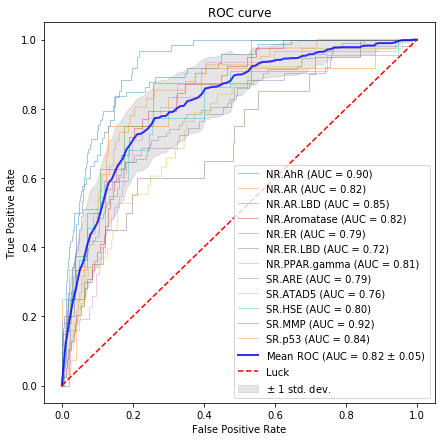

<Figure size 432x288 with 0 Axes>

In [4]:
out_dir = 'output_test/ensemble_predict/331x331'
os.makedirs(out_dir, exist_ok=True)
roc_curve.plot_roc(out_dir+'/test', y_true_list, y_pred_ensemble_list)